<a href="https://colab.research.google.com/github/faiqkhanpak/Faiq-Ahmad-Khan/blob/main/fuzzy_epilepsy_EXAI_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299)]             0         
                                                                 
 model (Functional)          (None, 3)                 43683     
                                                                 
 fuzzy1 (FuzzyLayer)         (None, 192)               64        
                                                                 
 fuzzy2 (FuzzyLayer)         (None, 6144)              32        
                                                                 
 fuzzy3 (FuzzyLayer)         (None, 98304)             16        
                                                                 
 dense_3 (Dense)             (None, 1)                 98305     
                                                                 
Total params: 142100 (555.08 KB)
Trainable params: 142100 (

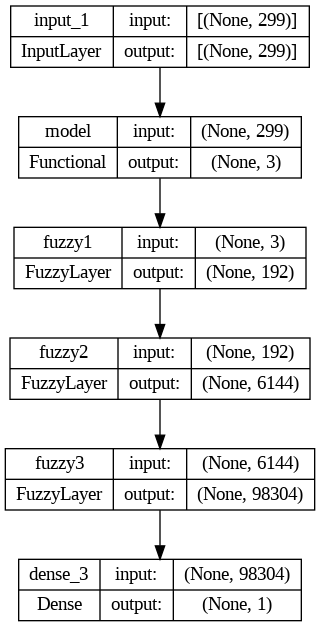

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model

# Load data (replace '.csv' with your actual file)
df = pd.read_excel('/content/chb_mit2.xlsx')

# Extract features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
std=StandardScaler()
X1=std.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Custom Fuzzy Layer
class FuzzyLayer(layers.Layer):
    def __init__(self, num_fuzzy_sets, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.num_fuzzy_sets = num_fuzzy_sets

    def build(self, input_shape):
        # Define fuzzy parameters (membership functions, etc.)
        self.membership_functions = [self.add_weight(name=f'mf_{i}', shape=(1,), initializer='uniform', trainable=True) for i in range(self.num_fuzzy_sets)]

    def call(self, inputs):
        # Implement the fuzzy logic operations
        fuzzy_outputs = [tf.math.exp(-tf.square(inputs - mf)) for mf in self.membership_functions]
        return tf.concat(fuzzy_outputs, axis=-1)

# Define the model architecture
input_dim = X.shape[1]
latent_dim = 3

inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
base_model = keras.Model(inputs, z)

x = base_model(inputs)
x = FuzzyLayer(64, name="fuzzy1")(x)
x = FuzzyLayer(32, name="fuzzy2")(x)
x = FuzzyLayer(16, name="fuzzy3")(x)

x = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
fuzzy_model = keras.Model(inputs, x)

# Compile the model
fuzzy_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
fuzzy_model.summary()
# Plot the model
plot_model(fuzzy_model, to_file='fuzzy_model_plot.png', show_shapes=True, show_layer_names=True)


28/28 [==============================] - 0s 2ms/step
Accuracy: 87.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       488
           1       0.80      0.95      0.87       387

    accuracy                           0.87       875
   macro avg       0.88      0.88      0.87       875
weighted avg       0.88      0.87      0.87       875



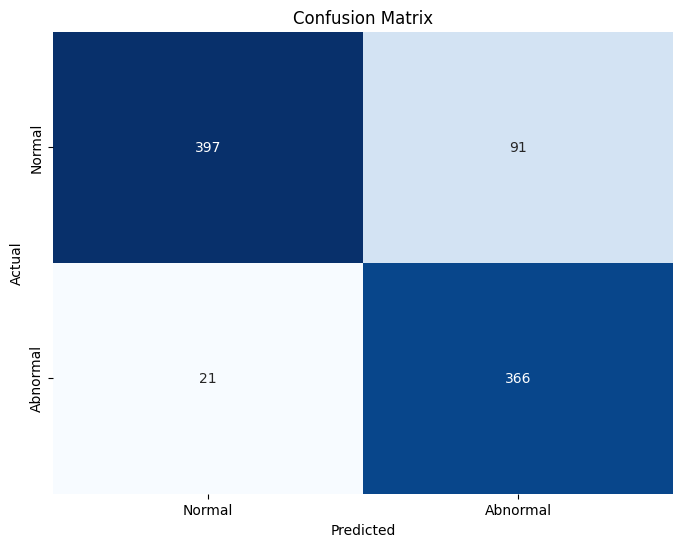

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Train the model
history=fuzzy_model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test))

# Perform predictions on the test set
y_pred = fuzzy_model.predict(X_test)
y_pred_binary = np.round(y_pred)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


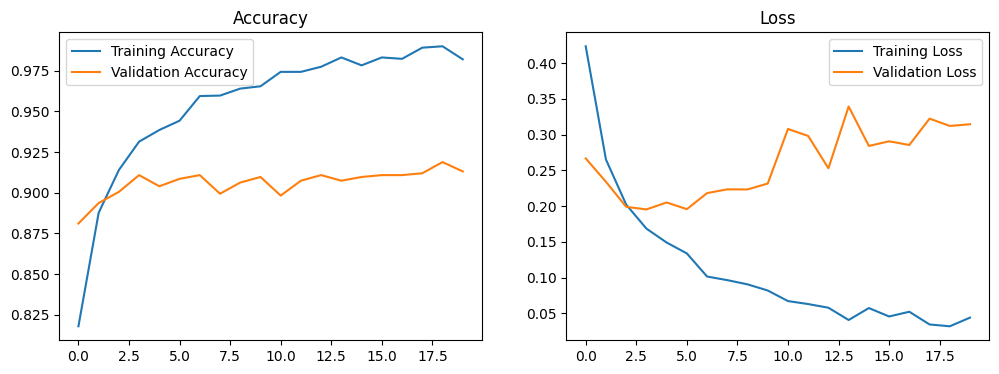

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

Text(0.5, 1.0, 'Accuracy Score: 91.31%')

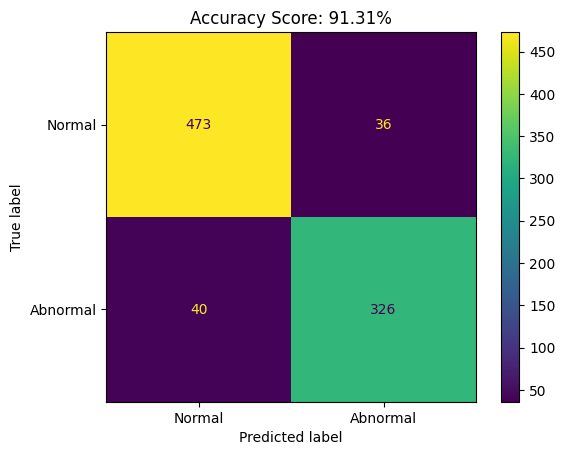

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
cm = confusion_matrix(y_test, y_pred_binary, labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.array(['Normal','Abnormal']))
disp.plot()
all_sample_title = 'Accuracy Score: {:.2f}%'.format((accuracy_score(y_test, y_pred_binary)*100))
plt.title(all_sample_title)

In [ ]:
# Use LIME for explanation
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode="classification", feature_names=df.columns[:-1], class_names=['Normal', 'Abnormal'])
i = np.random.randint(0, len(X_test))

# Modify the prediction function to return probability scores
prediction_function = lambda x: np.column_stack([1 - fuzzy_model.predict(x), fuzzy_model.predict(x)])

explanation = explainer.explain_instance(X_test[i], prediction_function, num_features=10)

# Display LIME explanation
explanation.show_in_notebook(show_all=False)